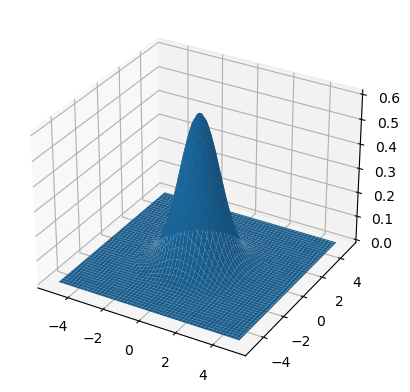

In [45]:
# define a 2d gaussian function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


#define a 2d gaussian function that decays exponentially as a function of time
def gaussian_t(x, y, x0, y0, sigma, t):
    decayConstant = 0.5
    return np.exp(-((x-x0)**2 + (y-y0)**2)/(2*sigma**2)) * np.exp(-decayConstant*t)

# define a grid between -5 and 5 (representing km)
x = np.linspace(-5, 5, 100)

# create a meshgrid
X, Y = np.meshgrid(x, x)

# create the 2d gaussian
Z = gaussian_t(X, Y, 0, 0, 1, 1)

# plot the 2d gaussian
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()


In [46]:
initial_uncertainty = 0.2 #200 meters
uncertainty_decay = 0.1
minimum_uncertainty = 0.05 #50 meters
meas_uncertainty = 0.01
n_detectors = 50
n_time_samples = 10

# create a list of n_samples random x and y values within the range -5 to 5
x_test = np.random.uniform(-5, 5, n_detectors)
y_test = np.random.uniform(-5, 5, n_detectors)

# sample the 2d gaussian at these x and y values for each time sample assuming they are sampled as a batch with a time step of 1
z_test = np.array([gaussian_t(x_test, y_test, 0, 0, 1, t) for t in range(n_time_samples)])
z_test = z_test.transpose()

(50,) (50,) (50, 10)
(50, 10) (50, 10) (50, 10)


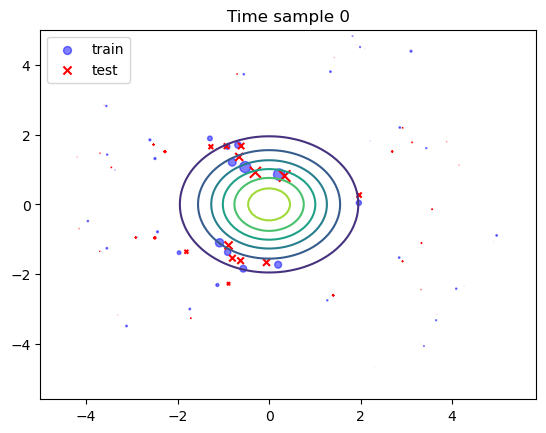

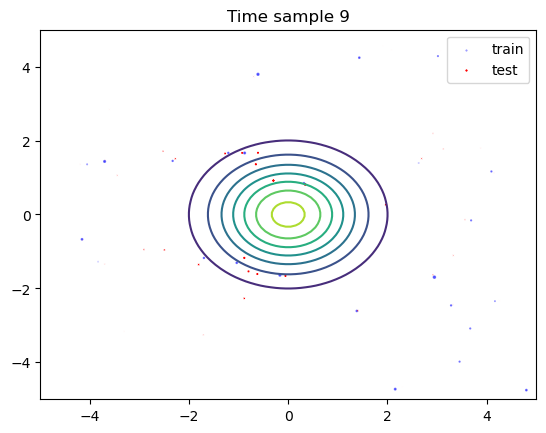

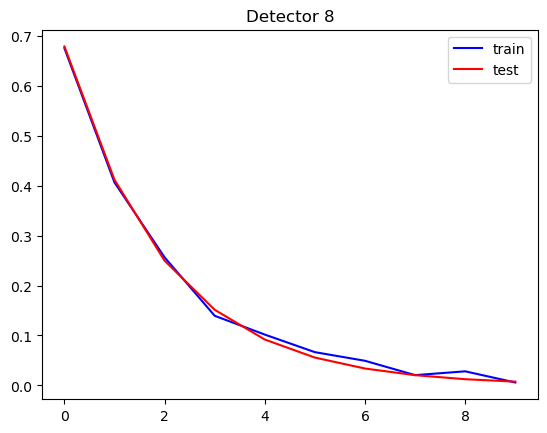

In [48]:

#modify the x,y's by adding a random number from a normal distribution with a mean of 0 and a standard deviation of 0.1
#reduce the location uncertainty exponentially from the initial uncertainty to the minimum uncertainty to mimic the effect of kalman filtering
loc_uncertainties = initial_uncertainty * np.exp(-uncertainty_decay*np.arange(n_time_samples))
loc_uncertainties[loc_uncertainties < minimum_uncertainty] = minimum_uncertainty

x_train = np.zeros((n_detectors, n_time_samples))
y_train = np.zeros((n_detectors, n_time_samples))

for d in range(n_detectors):
  for t in range(n_time_samples):
    x_train[d,t] = x_test[d] + np.random.normal(0, loc_uncertainties[t])
    y_train[d,t] = y_test[d] + np.random.normal(0, loc_uncertainties[t])

#modify the z's by adding a random number from a normal distribution with a mean of 0 and a standard deviation of 0.1
z_train = z_test + np.random.normal(0, meas_uncertainty, (n_detectors, n_time_samples))

print(x_test.shape, y_test.shape, z_test.shape)
print(x_train.shape, y_train.shape, z_train.shape)

# plot the random samples and their values represented by the size of the marker with blue circles for the train data and red crosses for the test data
# plot the nth time sample
n = 0
plt.scatter(x_train[:,n], y_train[:,n], s=z_train[:,n]*100, c='b', alpha=0.5, label='train')
plt.scatter(x_test, y_test, s=z_test[:,n]*100, c='r', marker='x', label='test')
plt.contour(X, Y, gaussian_t(X, Y, 0, 0, 1, n))
plt.title('Time sample ' + str(n))
plt.legend()
plt.show()

n = 9
plt.scatter(x_train[:,n], y_train[:,n], s=z_train[:,n]*100, c='b', alpha=0.5, label='train')
plt.scatter(x_test, y_test, s=z_test[:,n]*100, c='r', marker='x', label='test')
plt.contour(X, Y, gaussian_t(X, Y, 0, 0, 1, n))
plt.title('Time sample ' + str(n))
plt.legend()
plt.show()

#plot the reading for a single detector over time, choose the detector with the highest reading at the first time sample
d = np.argmax(z_test[:,0])
plt.plot(z_train[d,:], 'b', label='train')
plt.plot(z_test[d,:], 'r', label='test')
plt.title('Detector ' + str(d))
plt.legend()
plt.show()

